In [428]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [429]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [430]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 4800
Test set size: 1200


In [431]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))
t_theta_data_tmp = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arctan2(train_RO_se3s[i][1,0],train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))
test_t_y_data = np.zeros(len(test_RO_timestamps))
test_t_theta_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]
    test_t_y_data[i] = test_RO_se3s[i][1,3]
    test_t_theta_data[i] = np.arctan2(test_RO_se3s[i][1,0],test_RO_se3s[i][0,0])

In [432]:
num_features = 3
num_frames = 3
input_size = num_features * num_frames
output_size = num_features

In [433]:
# # from dataset_prep import prepare_data

# def prepare_data_tmp(dim1_data_scaled,dim2_data_scaled,dim3_data_scaled,train_validate_ratio,num_features,num_frames,input_size,output_size):
#     """
#     Data preparation
    
#     For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
#     [x1,y1,th1,x2,y2,th2]
#     These are offset, so that x1 goes up until the second last frame
#     (current frame is treated as future prediction)

#     Output tensor holds single frame, for x, y, and theta values
#     This is cropped to exclude the first n frames (n=2 here) and run up until the end
#     So a synthesised 'future' value to aim for

#     """
#     import torch
#     from torch.utils.data.dataset import TensorDataset

#     t_x = torch.tensor(dim1_data_scaled)
#     t_y = torch.tensor(dim2_data_scaled)
#     t_theta = torch.tensor(dim3_data_scaled)

# #     x_data = torch.zeros(len(dim1_data_scaled)-num_frames,input_size)
#     x_data = torch.zeros(len(dim1_data_scaled) - num_frames,input_size)
#     print('x_data dimensions:',x_data.size())

#     start_idx = 0
#     end_idx = len(x_data)
#     frame_idx = num_frames - 1

#     for i in range(num_frames):
#         x_data[:,frame_idx*num_features+2] = t_theta[start_idx:end_idx]
#         x_data[:,frame_idx*num_features+1] = t_y[start_idx:end_idx]
#         x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
#         start_idx+=1
#         end_idx+=1
#         frame_idx-=1 # older frames are assigned to later columns
#     print(x_data)

# #     y_data = torch.zeros(len(dim1_data_scaled)-num_frames,output_size)
#     y_data = torch.zeros(len(dim1_data_scaled) - num_frames,output_size)
#     print('y_data dimensions:',y_data.size())
#     y_data[:,0] = t_x[num_frames:]
#     y_data[:,1] = t_y[num_frames:]
#     y_data[:,2] = t_theta[num_frames:]
    
#     x_rows = x_data.size()[0]
#     training_idx_limit = int(train_validate_ratio * x_rows)

#     x_train = x_data[:training_idx_limit,:]
#     x_valid = x_data[training_idx_limit:,:]

#     y_train = y_data[:training_idx_limit,:]
#     y_valid = y_data[training_idx_limit:,:]

#     print('x_data dimensions:',x_data.size())
#     print('x_train dimensions:',x_train.size())
#     print('x_valid dimensions:',x_valid.size())
#     print('y_data dimensions:',y_data.size())
#     print('y_train dimensions:',y_train.size())
#     print('y_valid dimensions:',y_valid.size())
    
#     train_ds = TensorDataset(x_train,y_train)
#     valid_ds = TensorDataset(x_valid,y_valid)
    
#     return train_ds, valid_ds

# train_validate_ratio = 0.8

# # For unit testing:
# dim1_data_scaled = np.array([0,1,2,3,4])
# dim2_data_scaled = np.array([0,.1,.2,.3,.4])
# dim3_data_scaled = np.array([0,.1,.2,.3,.4])

# train_ds,valid_ds = \
# prepare_data_tmp(dim1_data_scaled,dim2_data_scaled,dim3_data_scaled, \
#              train_validate_ratio,num_features,num_frames,input_size,output_size)

# print(dim1_data_scaled[0])
# print(dim1_data_scaled[1])
# print(dim1_data_scaled[2])
# print(dim1_data_scaled[3])
# print("\n")

# tmp_data_loader = DataLoader(dataset=train_ds,
#                                      batch_size=len(train_ds),
#                                      shuffle=False,
#                                      num_workers=1)
    
# batch_x, batch_y = next(iter(tmp_data_loader))
# print(batch_x[0,0])
# print(batch_x[1,0])
# # print(batch_x[2,0])

# print("\n")
# print(batch_y[0,0])
# print(batch_y[1,0])
# # print(batch_y[2,0])

In [434]:
dim1_data = t_x_data
dim2_data = t_y_data
dim3_data = t_theta_data

print('t_x_data dimensions:',t_x_data.shape)


dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
dim3_data_scaled = (dim3_data - dim3_data.mean())/dim3_data.std()

# from dataset_prep import prepare_data

def prepare_data_tmp(dim1_data_scaled,dim2_data_scaled,dim3_data_scaled,train_validate_ratio,num_features,num_frames,input_size,output_size):
    """
    Data preparation
    
    For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
    [x1,y1,th1,x2,y2,th2]
    These are offset, so that x1 goes up until the second last frame
    (current frame is treated as future prediction)

    Output tensor holds single frame, for x, y, and theta values
    This is cropped to exclude the first n frames (n=2 here) and run up until the end
    So a synthesised 'future' value to aim for

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(dim1_data_scaled)
    t_y = torch.tensor(dim2_data_scaled)
    t_theta = torch.tensor(dim3_data_scaled)

#     x_data = torch.zeros(len(dim1_data_scaled)-num_frames,input_size)
    x_data = torch.zeros(len(dim1_data_scaled) - num_frames,input_size)
    print('x_data dimensions:',x_data.size())

    start_idx = 0
    end_idx = len(x_data)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_data[:,frame_idx*num_features+2] = t_theta[start_idx:end_idx]
        x_data[:,frame_idx*num_features+1] = t_y[start_idx:end_idx]
        x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns
    print(x_data)

#     y_data = torch.zeros(len(dim1_data_scaled)-num_frames,output_size)
    y_data = torch.zeros(len(dim1_data_scaled) - num_frames,output_size)
    print('y_data dimensions:',y_data.size())
    y_data[:,0] = t_x[num_frames:]
    y_data[:,1] = t_y[num_frames:]
    y_data[:,2] = t_theta[num_frames:]
    
    x_rows = x_data.size()[0]
    training_idx_limit = int(train_validate_ratio * x_rows)

    x_train = x_data[:training_idx_limit,:]
    x_valid = x_data[training_idx_limit:,:]

    y_train = y_data[:training_idx_limit,:]
    y_valid = y_data[training_idx_limit:,:]

    print('x_data dimensions:',x_data.size())
    print('x_train dimensions:',x_train.size())
    print('x_valid dimensions:',x_valid.size())
    print('y_data dimensions:',y_data.size())
    print('y_train dimensions:',y_train.size())
    print('y_valid dimensions:',y_valid.size())
    
    train_ds = TensorDataset(x_train,y_train)
    valid_ds = TensorDataset(x_valid,y_valid)
    
    return train_ds, valid_ds

train_validate_ratio = 0.8

train_ds,valid_ds = \
prepare_data_tmp(dim1_data_scaled,dim2_data_scaled,dim3_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

t_x_data dimensions: (4800,)
x_data dimensions: torch.Size([4797, 9])
tensor([[-1.4102, -0.0418,  0.0206,  ..., -1.4136,  0.0366,  0.0203],
        [-1.4149, -0.2067,  0.0201,  ..., -1.4124, -0.0772,  0.0204],
        [-1.4128, -0.0113,  0.0206,  ..., -1.4102, -0.0418,  0.0206],
        ...,
        [ 1.4719, -0.2721,  0.0356,  ...,  1.4194, -0.6839,  0.1149],
        [ 1.3866, -0.7392, -0.0064,  ...,  1.4335, -0.1796,  0.1562],
        [ 1.4792, -0.5443,  0.0152,  ...,  1.4719, -0.2721,  0.0356]])
y_data dimensions: torch.Size([4797, 3])
x_data dimensions: torch.Size([4797, 9])
x_train dimensions: torch.Size([3837, 9])
x_valid dimensions: torch.Size([960, 9])
y_data dimensions: torch.Size([4797, 3])
y_train dimensions: torch.Size([3837, 3])
y_valid dimensions: torch.Size([960, 3])


In [435]:
test_dim1_data = test_t_x_data
test_dim2_data = test_t_y_data
test_dim3_data = test_t_theta_data

# We won't have access to mean and std of the test data, so must use the training set mean and std to do scaling
test_dim1_data_scaled = (test_dim1_data - dim1_data.mean())/dim1_data.std()
test_dim2_data_scaled = (test_dim2_data - dim2_data.mean())/dim2_data.std()
test_dim3_data_scaled = (test_dim3_data - dim3_data.mean())/dim3_data.std()

def prepare_test_data(test_dim1_data_scaled,test_dim2_data_scaled,test_dim3_data_scaled,num_features,num_frames,input_size,output_size):
    """
    Data preparation for test data

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(test_dim1_data_scaled)
    t_y = torch.tensor(test_dim2_data_scaled)
    t_theta = torch.tensor(test_dim3_data_scaled)

    x_test = torch.zeros(len(test_dim1_data_scaled) - num_frames + 1,input_size)
    start_idx = 0
    end_idx = len(x_test)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_test[:,frame_idx*num_features+2] = t_theta[start_idx:end_idx]
        x_test[:,frame_idx*num_features+1] = t_y[start_idx:end_idx]
        x_test[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns

    y_test = torch.zeros(len(test_dim1_data_scaled) - num_frames + 1,output_size)
    y_test[:,0] = t_x[num_frames-1:]
    y_test[:,1] = t_y[num_frames-1:]
    y_test[:,2] = t_theta[num_frames-1:]

    print('x_test dimensions:',x_test.size())
    print('y_test dimensions:',y_test.size())
    
    test_ds = TensorDataset(x_test,y_test)
    
    return test_ds

test_ds = prepare_test_data(test_dim1_data_scaled,test_dim2_data_scaled,test_dim3_data_scaled, \
                            num_features,num_frames,input_size,output_size)

x_test dimensions: torch.Size([1198, 9])
y_test dimensions: torch.Size([1198, 3])


In [436]:
tmp = np.array([0,1,2])
print(tmp[:len(tmp)])

[0 1 2]


In [476]:
import torch.nn as nn
#our class must extend nn.Module
class BiggerNetwork(nn.Module):
    def __init__(self):
        super(BiggerNetwork,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(input_size,3)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(3,output_size)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = torch.relu(x) # F.tanh(x)
        #This produces output
        x = self.fc2(x)
        return x 
    
class ExperimentalNetwork(nn.Module):
    def __init__(self):
        super(BiggerNetwork,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(input_size,100)

        # experimenting
        self.fc12 = nn.Linear(100,30)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(30,output_size)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = torch.relu(x) # F.tanh(x)
        
        #experimenting
        x = self.fc12(x)
        x = torch.tanh(x) # F.tanh(x)

        #This produces output
        x = self.fc2(x)
        return x 
    
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

In [480]:
from network_helpers import *

def loss_batch_tmp(model,loss_func,xb,yb,opt=None):    
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch_tmp(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch_tmp(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

def weighted_mse_loss(input, target):
#     return torch.mean((input - target) ** 2)
    weight = torch.FloatTensor(3)
    weight[0] = 1
    weight[1] = 2
    weight[2] = 2 #2 # tweaking this to give theta more importance so it won't be optimised out
    err = input - target
    serr = err ** 2
    werr = weight * serr
    l = torch.mean(werr)
    return l

batch_size = 50
epochs = 50#100
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = BiggerNetwork() #SimpleNetwork()
# loss_func = nn.SmoothL1Loss() #weighted_mse_loss #nn.CrossEntropyLoss()
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, optimizer, train_dl, valid_dl)


0 0.6149231574187676
1 0.5179503662511706
2 0.42692128475755453
3 0.3552473387680948
4 0.3041109985982378
5 0.27096027434648323
6 0.24935779503236213
7 0.23365528555586934
8 0.2209944620456857
9 0.21078635870556658
10 0.2021362263088425
11 0.19566077702135468
12 0.19157572653299818
13 0.18875808431766927
14 0.18705180320345485
15 0.18607776057130346
16 0.18507958449966586
17 0.1845841706963256
18 0.18426933065832904
19 0.1837794639674636
20 0.18350967551426342
21 0.183221483118056
22 0.18265199073357508
23 0.18268819911948717
24 0.1825951110998479
25 0.1821661765764778
26 0.18207979660170773
27 0.182143701298628
28 0.18197871736871699
29 0.1817244108339461
30 0.18166981294052675
31 0.18147710452709967
32 0.18171156170622757
33 0.1815096779804056
34 0.1815660556894727
35 0.1811856507556513
36 0.18104743759613484
37 0.18127856065984815
38 0.18116828669250631
39 0.1813264777107785
40 0.18148291809484363
41 0.18137530136543015
42 0.1808443286572583
43 0.18119573162402958
44 0.1808913853795

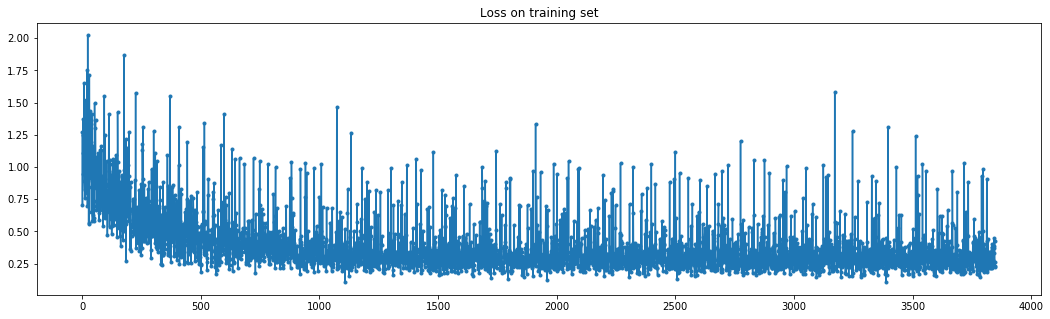

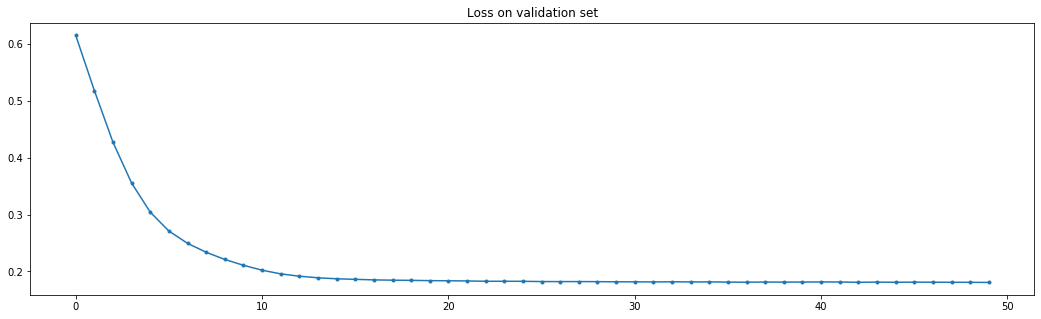

In [481]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

torch.Size([3837, 9]) torch.Size([3837, 3]) torch.Size([3837, 3])
Batch x row: tensor([ 0.9938, -0.2047, -0.1619,  0.8626,  0.1944, -0.3102,  0.8121, -0.3793,
        -0.0996])
Batch y row: tensor([ 0.9631, -0.3503, -0.0409])
Batch y row (prev): tensor([ 0.9938, -0.2047, -0.1619])
tensor(0.0395)


Text(0.5, 1.0, 'Pose in x direction for training set')

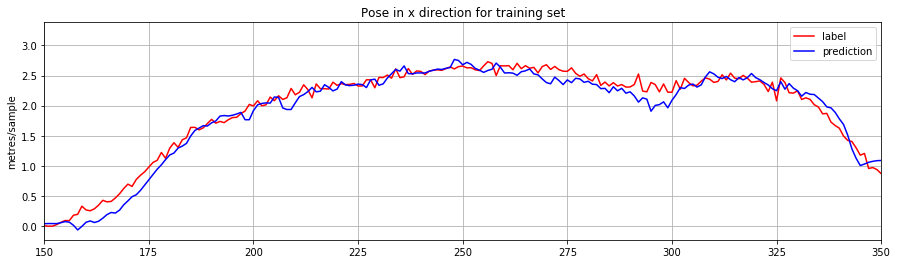

In [482]:
train_data_loader = DataLoader(dataset=train_ds,
                                     batch_size=len(train_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(train_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape, prediction.shape)

print("Batch x row:",batch_x[200,:])
# print(batch_x[1,0])
# print(batch_x[2,0])

print("Batch y row:",batch_y[200,:])
print("Batch y row (prev):",batch_y[199,:])
# print(batch_y[1,0])
# print(batch_y[2,0])

rescaled_gt_x = batch_y[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_gt_y = batch_y[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_gt_theta = batch_y[:,2]*dim3_data.std() + dim3_data.mean()
rescaled_prediction_x = prediction[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_prediction_y = prediction[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_prediction_theta = prediction[:,2]*dim3_data.std() + dim3_data.mean()

# x_limits = (0,1000)
x_limits = (150,350)

plt.figure(figsize=(15,4))
plt.plot(rescaled_gt_x,'r',label="label")
plt.plot(rescaled_prediction_x,'b',label="prediction")
# plt.plot(rescaled_prediction_x[1:],'g',label="prediction")
print(rescaled_prediction_x[0])
plt.grid()
plt.legend()
plt.xlim(x_limits)
plt.ylabel("metres/sample")
plt.title("Pose in x direction for training set")

# plt.figure(figsize=(15,4))
# plt.plot(rescaled_gt_y,'r',label="label")
# plt.plot(rescaled_prediction_y,'b',label="prediction")
# plt.grid()
# plt.legend()
# plt.xlim(x_limits)
# plt.ylabel("metres/sample")
# plt.title("Pose in y direction for training set")

# plt.figure(figsize=(15,4))
# plt.plot(rescaled_gt_theta,'r',label="label")
# plt.plot(rescaled_prediction_theta,'b',label="prediction")
# plt.grid()
# plt.legend()
# plt.xlim(x_limits)
# plt.ylabel("rad/sample")
# plt.title("Pose in theta direction for training set")

torch.Size([960, 9]) torch.Size([960, 3]) torch.Size([960, 3])


Text(0.5, 1.0, 'Pose in theta direction for validation set')

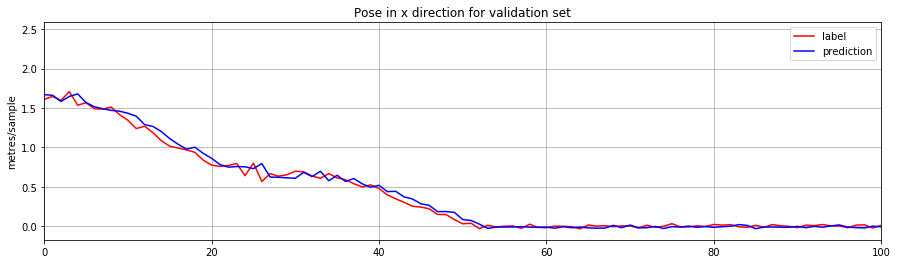

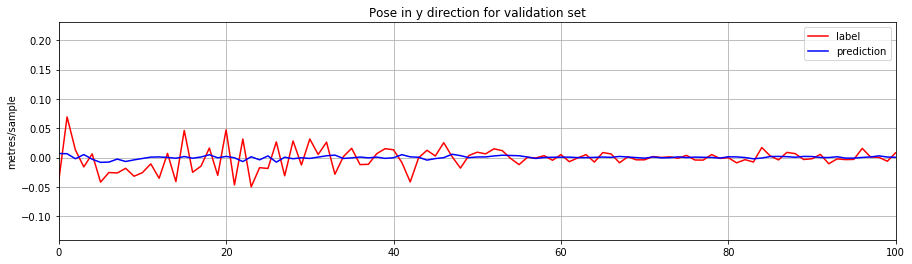

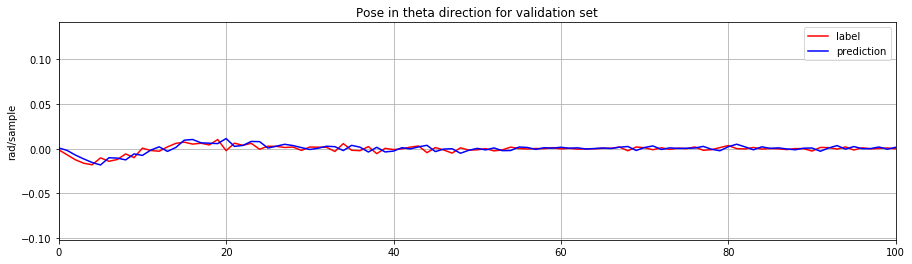

In [441]:
valid_data_loader = DataLoader(dataset=valid_ds,
                                     batch_size=len(valid_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(valid_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape, prediction.shape)

rescaled_gt_x = batch_y[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_prediction_x = prediction[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_gt_y = batch_y[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_prediction_y = prediction[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_gt_theta = batch_y[:,2]*dim3_data.std() + dim3_data.mean()
rescaled_prediction_theta = prediction[:,2]*dim3_data.std() + dim3_data.mean()

x_limits = (0,100)

plt.figure(figsize=(15,4))
plt.plot(rescaled_gt_x,'r',label="label")
plt.plot(rescaled_prediction_x,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(x_limits)
plt.ylabel("metres/sample")
plt.title("Pose in x direction for validation set")

plt.figure(figsize=(15,4))
plt.plot(rescaled_gt_y,'r',label="label")
plt.plot(rescaled_prediction_y,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(x_limits)
plt.ylabel("metres/sample")
plt.title("Pose in y direction for validation set")

plt.figure(figsize=(15,4))
plt.plot(rescaled_gt_theta,'r',label="label")
plt.plot(rescaled_prediction_theta,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(x_limits)
plt.ylabel("rad/sample")
plt.title("Pose in theta direction for validation set")

torch.Size([1198, 9]) torch.Size([1198, 3]) torch.Size([1198, 3])


Text(0.5, 1.0, 'Pose in theta direction for test set')

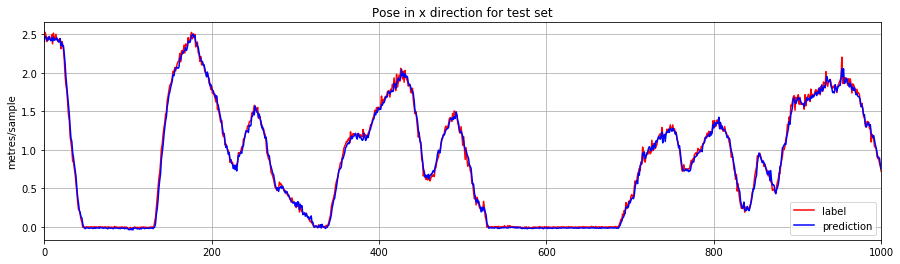

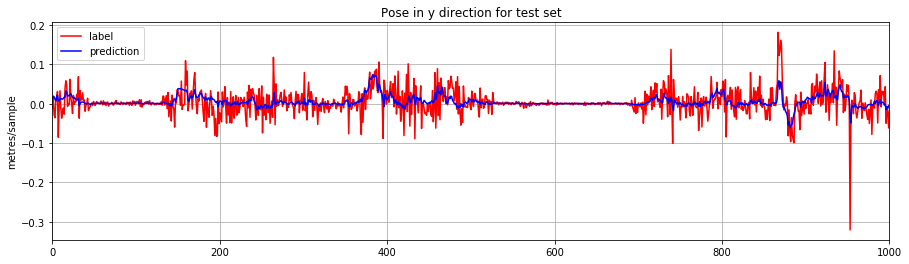

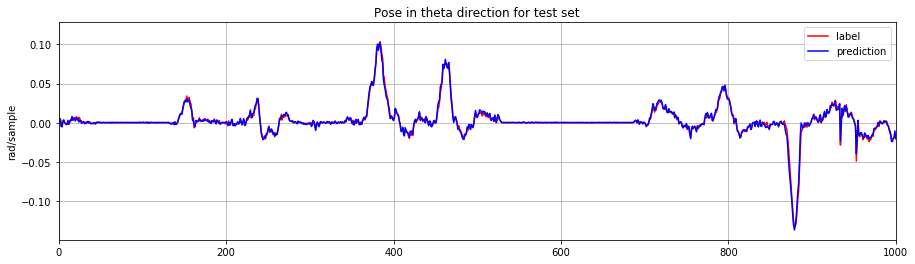

In [442]:
test_data_loader = DataLoader(dataset=test_ds,
                                     batch_size=len(test_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(test_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape, prediction.shape)

rescaled_gt_x = batch_y[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_prediction_x = prediction[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_gt_y = batch_y[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_prediction_y = prediction[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_gt_theta = batch_y[:,2]*dim3_data.std() + dim3_data.mean()
rescaled_prediction_theta = prediction[:,2]*dim3_data.std() + dim3_data.mean()

x_limits = (0,1000)

plt.figure(figsize=(15,4))
plt.plot(rescaled_gt_x,'r',label="label")
plt.plot(rescaled_prediction_x,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(x_limits)
plt.ylabel("metres/sample")
plt.title("Pose in x direction for test set")

plt.figure(figsize=(15,4))
plt.plot(rescaled_gt_y,'r',label="label")
plt.plot(rescaled_prediction_y,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(x_limits)
plt.ylabel("metres/sample")
plt.title("Pose in y direction for test set")

plt.figure(figsize=(15,4))
plt.plot(rescaled_gt_theta,'r',label="label")
plt.plot(rescaled_prediction_theta,'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(x_limits)
plt.ylabel("rad/sample")
plt.title("Pose in theta direction for test set")